<a href="https://colab.research.google.com/github/2303A52324/Explainable-AI-Assignment/blob/main/Lab_As_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Load Data set

In [3]:

df = pd.read_csv("/content/drive/MyDrive/AmesHousing.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


 Preprocessing

In [4]:
target = "SalePrice"
X = df.drop(columns=[target])
y = df[target]

X = pd.get_dummies(X, drop_first=True)

print("Final features shape:", X.shape)
X.head()


Final features shape: (2930, 262)


,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1,526301100,20,141.0,31770,6,5,1960,1960,112.0,...,False,False,False,False,True,False,False,False,True,False
1,2,526350040,20,80.0,11622,5,6,1961,1961,0.0,...,False,False,False,False,True,False,False,False,True,False
2,3,526351010,20,81.0,14267,6,6,1958,1958,108.0,...,False,False,False,False,True,False,False,False,True,False
3,4,526353030,20,93.0,11160,7,5,1968,1968,0.0,...,False,False,False,False,True,False,False,False,True,False
4,5,527105010,60,74.0,13830,5,5,1997,1998,0.0,...,False,False,False,False,True,False,False,False,True,False


Training and spliting

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

Evaluate Model

In [6]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.3f}")


Model Performance:
RMSE: 26522.92
MAE:  15753.59
R²:   0.912


SHAP Explainer Setup

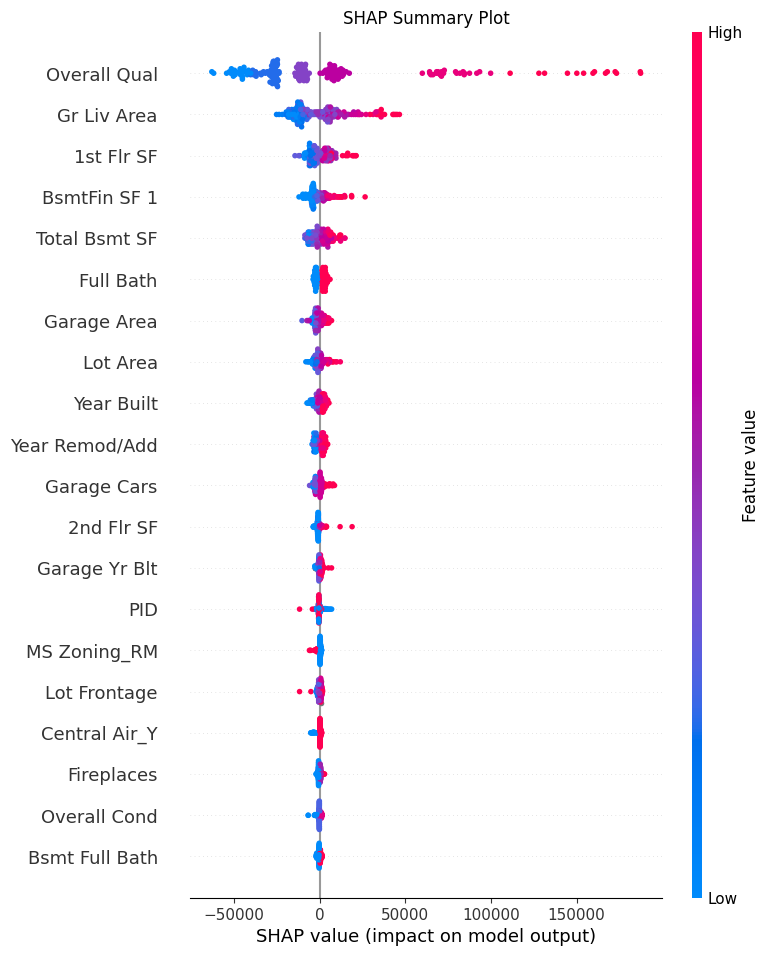

In [7]:
explainer = shap.TreeExplainer(model)
X_sample = X_test.sample(n=200, random_state=42)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot")
plt.show()

#SHAP Dependence plot

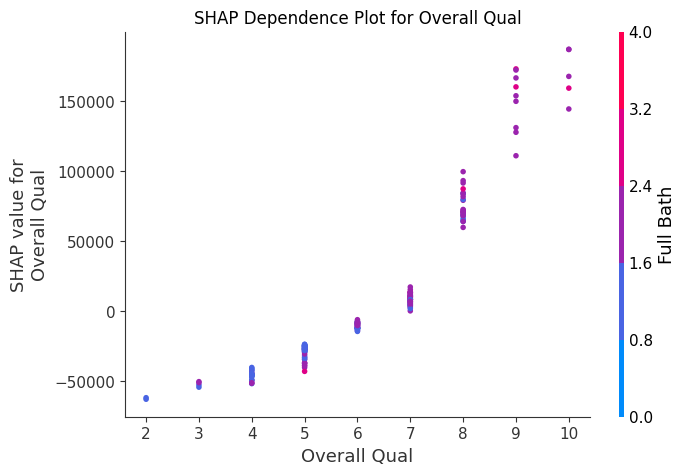

In [8]:
top_feature = X.columns[np.argsort(np.abs(shap_values).mean(axis=0))[::-1][0]]
shap.dependence_plot(top_feature, shap_values, X_sample, show=False)
plt.title(f"SHAP Dependence Plot for {top_feature}")
plt.show()

SHAP WAterwall plot

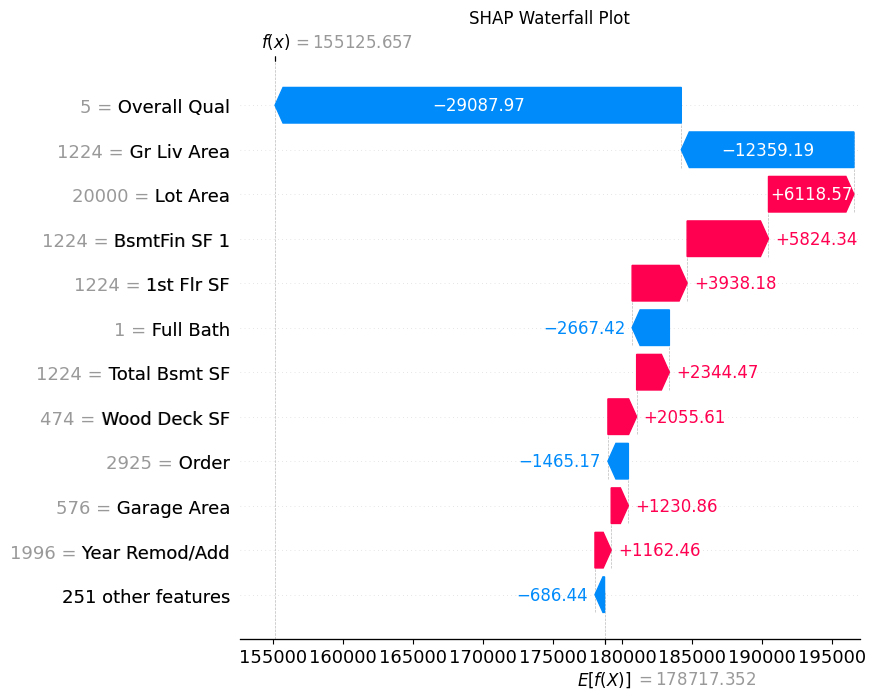

In [9]:
i = 0  # pick the first row in sample
exp = shap.Explanation(
    values=shap_values[i],
    base_values=np.array([explainer.expected_value]),
    data=X_sample.iloc[i, :].values,
    feature_names=X_sample.columns.tolist()
)
shap.plots.waterfall(exp, max_display=12, show=False)
plt.title("SHAP Waterfall Plot")
plt.show()

Feature Importance

In [10]:
importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nTop 10 features by model importance:")
importances.sort_values(ascending=False).head(10)



Top 10 features by model importance:


,0
Overall Qual,0.606214
Gr Liv Area,0.098343
1st Flr SF,0.038474
Total Bsmt SF,0.025796
BsmtFin SF 1,0.022899
2nd Flr SF,0.022159
Full Bath,0.017676
Garage Cars,0.017036
Garage Area,0.015373
Lot Area,0.015298
